In [1]:
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# infile = 'food/meta/train.json'
# with open(infile) as json_file:  
#     data = json.load(json_file)


In [ ]:
!pip install imgaug


In [2]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

# random example images
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
#                 sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
#                 iaa.OneOf([
#                     iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
#                     iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
#                     iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
#                 ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
#                 iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                 iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
#                 # either change the brightness of the whole image (sometimes
#                 # per channel) or change the brightness of subareas
#                 iaa.OneOf([
#                     iaa.Multiply((0.5, 1.5), per_channel=0.5),
#                     iaa.FrequencyNoiseAlpha(
#                         exponent=(-4, 0),
#                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                         second=iaa.ContrastNormalization((0.5, 2.0))
#                     )
#                 ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
#                 iaa.Grayscale(alpha=(0.0, 1.0)),
#                 sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                 sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

images_aug = seq.augment_images(images)



In [3]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, infile, batch_size=128, is_training = True):
        with open(infile) as json_file:  
            data = json.load(json_file)
#         newdata = dict()
#         for name in data.keys():
#             if name[0] in 'abcd':
#                 newdata[name] = data[name]                
#         data = newdata
        self.num_classes = len(data.keys())
        self.is_training = is_training
        print("Number of classes: " + str(self.num_classes))

        self.batch_size=batch_size

        self.labels = list()
        
        self.filenames = list()
        self.label_names = sorted(data.keys())
        for index, key in enumerate(self.label_names):
            for image in data[key]:
                self.filenames.append(image)
                self.labels.append(index)
        print("filenames len: ", len(self.filenames), " labels len: ", len(self.labels))
        self.num_images = len(self.filenames)            
        self.indices = np.arange(self.num_images)
        self.on_epoch_end()
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(self.num_images / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data..."""
        # Generate indexes of the batch
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        images = list()
        labels = list()
        for i in indexes:
            filename = self.filenames[i]
            label = self.labels[i]            
            basepath = 'food/images/'
            path = basepath + filename + ".jpg"
            img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
            x = tf.keras.preprocessing.image.img_to_array(img)
            assert(x.shape == (224, 224, 3))

            images.append(x)
            labels.append(label)
            
        if self.is_training:
            images = seq.augment_images(images)

        temp = np.array(images)

#         unresized_images = tf.keras.applications.resnet50.preprocess_input(temp)
        unresized_images = tf.keras.applications.mobilenet.preprocess_input(temp)

        return np.array(unresized_images), tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.indices)
         
train_generator = DataGenerator('food/meta/train.json', is_training=True)
test_generator = DataGenerator('food/meta/test.json', is_training=False)

firstitem = train_generator.__getitem__(0)

# for i in range(1):
#     firstitem = train_generator.__getitem__(i)
#     for x, label in zip(firstitem[0], firstitem[1]):
#         plt.imshow(x)
#         plt.show()
#         print(label)

Number of classes: 101
filenames len:  75750  labels len:  75750
Number of classes: 101
filenames len:  25250  labels len:  25250


In [ ]:
# gen = tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)


In [ ]:
#gen.fit(train_generator)

In [ ]:
# train_generator.label_names

In [ ]:
firstitem = train_generator.__getitem__(50)


In [ ]:
firstitem[0].shape

In [ ]:
test_generator.label_names == train_generator.label_names

In [ ]:
# firstitem[1]

In [ ]:
# network = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
network = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = network.output
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x=tf.keras.layers.Flatten()(x)
# x=tf.keras.layers.Dense(512,activation='relu')(x)
preds=tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x) #final layer with softmax activation
model=tf.keras.Model(inputs=network.input,outputs=preds)

model = tf.keras.utils.multi_gpu_model( model, 4) # before first epoch 689, second epoch 671. After: 837 seconds
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
count_n = 0
with open('count_run.txt') as f:
    count_n = int(f.readline())
with open('count_run.txt', 'w') as f:
    f.write(str(count_n+1) + '\n')
    
mycallbacks = [tf.keras.callbacks.TensorBoard(log_dir='./runs/'+str(count_n), write_graph=True, write_grads=True,write_images=True)]
# mycallbacks=[]
print(count_n)

In [ ]:
# model.fit_generator(train_generator_from_folder, epochs=5, workers=16, validation_data=test_generator, callbacks=mycallbacks)
model.fit_generator(train_generator, 
                    epochs=50, 
#                     max_queue_size=100, 
                    use_multiprocessing=True, 
                    workers=16, 
                    validation_data=test_generator, 
                    callbacks=mycallbacks)

In [13]:
!apt-get install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 158 kB of archives.
After this operation, 587 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu xenial/main amd64 zip amd64 3.0-11 [158 kB]
Fetched 158 kB in 4s (38.0 kB/s)     
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package zip.
(Reading database ... 46679 files and directories currently installed.)
Preparing to unpack .../archives/zip_3.0-11_amd64.deb ...
Unpacking zip (3.0-11) ...
Processing triggers for man-db (2.7.5-1) ...
Setting up zip (3.0-11) ...


In [22]:
# output_path = tf.contrib.saved_model.save_keras_model(model, 'food_model')
model = tf.contrib.saved_model.load_keras_model("food_model/a")

In [18]:
output_path = str(output_path)[2:-1]
print(output_path)

food_model/1556990395


In [20]:
!zip -r cake_model {output_path}

updating: food_model/1556990395/ (stored 0%)
  adding: food_model/1556990395/saved_model.pb (deflated 92%)
  adding: food_model/1556990395/variables/ (stored 0%)
  adding: food_model/1556990395/variables/checkpoint (deflated 37%)
  adding: food_model/1556990395/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: food_model/1556990395/variables/variables.index (deflated 76%)
  adding: food_model/1556990395/assets/ (stored 0%)
  adding: food_model/1556990395/assets/saved_model.json (deflated 94%)


In [5]:
# model.save('cake_recognition_model.h5')

In [6]:
all_predictions = list()
all_true = list()
for i in range(len(test_generator)):
    images, labels = test_generator.__getitem__(i)
    predictions = model.predict(images)
    all_predictions.extend(predictions)
    all_true.extend(labels)


In [7]:
print(len(all_predictions))
print(all_predictions[0])
max_pred = [np.argmax(p) for p in all_predictions]
max_true = [np.argmax(p) for p in all_true]


25216
[3.95534499e-07 3.31931915e-05 5.65408627e-08 2.82941414e-07
 3.10855612e-05 8.25445568e-07 2.17817978e-06 7.91860020e-06
 1.63321056e-06 1.04405672e-05 6.57661212e-06 3.17035920e-05
 5.09673264e-08 8.37874177e-06 3.13447259e-07 1.27852516e-04
 6.05792302e-05 1.89383229e-07 1.25494774e-03 1.20750897e-07
 4.31825174e-05 6.88402224e-09 3.50180720e-08 4.75099199e-07
 5.13966188e-06 5.58372121e-05 3.95040244e-01 7.91085526e-08
 1.72758173e-05 1.10942983e-06 2.69208249e-06 4.20738661e-06
 1.39738750e-05 2.35149898e-07 3.58750665e-04 1.13749411e-06
 5.10116637e-01 1.20010730e-02 4.72888211e-03 3.28471901e-06
 4.61213716e-07 2.60527724e-08 1.15643952e-05 3.21384729e-03
 3.72019567e-04 1.51410804e-05 3.12455796e-07 9.75342482e-05
 4.27315850e-03 9.46861037e-05 5.44629507e-02 1.97342024e-06
 5.36936859e-08 2.61548936e-04 1.67733596e-08 1.28284209e-05
 3.34923447e-04 1.60264457e-03 2.70003761e-06 7.48392858e-06
 1.14897345e-08 1.00273865e-04 5.07575984e-04 1.51199842e-07
 9.22061094e-09 1.

In [8]:
total_correct = 0
for a, b in zip(max_pred, max_true):
    if a==b:
        total_correct += 1
print(total_correct / len(all_true))

0.8098429568527918


Confusion matrix, without normalization
[[143   0   6 ...   2   0   2]
 [  0 176   0 ...   0   0   0]
 [ 11   0 219 ...   0   0   2]
 ...
 [  1   0   1 ... 181   0   0]
 [  0   0   1 ...   1 173   0]
 [  4   0   0 ...   0   0 215]]


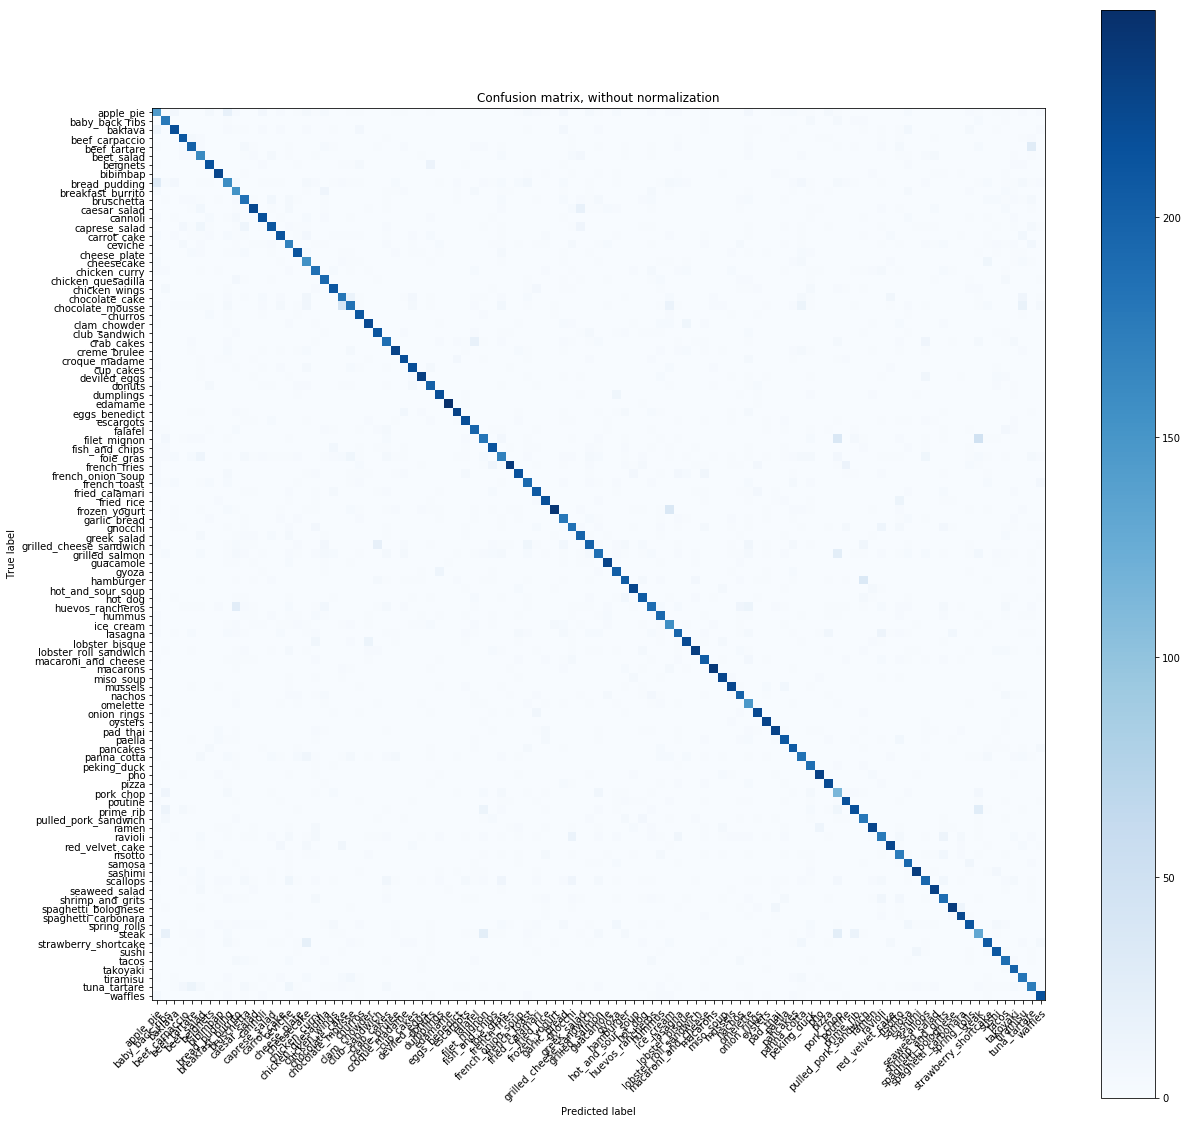

In [9]:



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    return fig, ax


np.set_printoptions(precision=2)
# class_names = iris.target_names
class_names = test_generator.label_names
# Plot non-normalized confusion matrix
fig, ax = plot_confusion_matrix(max_pred, max_true, classes=class_names,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()
fig.savefig('confusion_matrix.png')
fig.savefig('confusion_matrix.pdf')


In [ ]:
images, labels = test_generator.__getitem__(0)
predictions = model.predict(images)
for p, true in zip(predictions,labels):
    print(p.max(), " index ", p.argmax(), ' actual activation: ', p[true.argmax()])


for index in range(32):
    plt.imshow(images[index]*255)
    plt.show()
    print(train_generator.label_names[labels[index].argmax()])
    print(train_generator.label_names[predictions[index].argmax()])

In [ ]:
for i in range(100):
    images, labels = test_generator.__getitem__(0)
    predictions = model.predict(images)
    for p, true in zip(predictions,labels):
#         print(p.max(), " index ", p.argmax(), ' actual activation: ', p[true.argmax()])
        if p[0] > 0.2:
            plt.imshow(images[index]*255)
            plt.show()

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
